In [4]:
#!pip install tensorflow

In [5]:
#!pip install keras

In [6]:
#!pip install pennylane --upgrade

In [ ]:
#!pip install scikit-image

In [117]:
import pennylane as qml
from pennylane import numpy as np

In [71]:
from keras.models import Sequential
from keras.layers import Dense

In [72]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [217]:
import json
from Filters import *
from Data_load import data_load
import matplotlib.pyplot as plt

import keras

from utils import *

import time

## Import the images
data = data_load()
train_images, train_labels, test_images, test_labels = data.data_mnist()

6000


In [218]:
print("shape of train images", train_images[0].shape)
print("shape of test images", test_images[0].shape)

shape of train images (28, 28, 1)
shape of test images (28, 28, 1)


In [219]:
print("length of train images", len(train_images))
print("length of test images", len(test_images))

length of train images 6000
length of test images 1000


In [220]:
# This function returns the modified dataset
# It is a script to get a dataset of 2 labels only
def trainTestData(train_images, train_labels, test_images, test_labels, label1, label2, n_train, n_test):
    n_train_images, n_train_labels, n_test_images, n_test_labels = [], [], [], []
    i = 0
    while (n_train > 0 and i < len(train_images)):
        if train_labels[i] == label1:
            n_train_images.append(train_images[i])
            n_train_labels.append(label1)
            n_train -= 1
        if train_labels[i] == label2:
            n_train_images.append(train_images[i])
            n_train_labels.append(label2)
            n_train -= 1
        i = i+1
    i = 0
    while(n_test>0 and i < len(test_images)):
        if test_labels[i] == label1:
            n_test_images.append(test_images[i])
            n_test_labels.append(label1)
            n_test -= 1
        if test_labels[i] == label2:
            n_test_images.append(test_images[i])
            n_test_labels.append(label2)
            n_test -= 1
        i = i+1
    return n_train_images, n_train_labels, n_test_images, n_test_labels

In [239]:
train_images1, train_labels1, test_images1, test_labels1 = trainTestData(train_images,
                                                                     train_labels,
                                                                     test_images,
                                                                     test_labels, 0, 1, 1300, 20)
train_images2, train_labels2, test_images2, test_labels2 = trainTestData(train_images,
                                                                     train_labels,
                                                                     test_images,
                                                                     test_labels, 2, 3, 1300, 20)

In [240]:
# this functions makes the train dataset balanced
# number of images for number 3 same as that for number 5
def balanceDataSet(BAS, train_labels, x, y):
    new_train_images_x = []
    new_train_images_y = []

    new_train_labels_x = []
    new_train_labels_y = []

    for i in range(len(BAS)):
      if train_labels[i] == x:
        new_train_images_x.append(BAS[i])
        new_train_labels_x.append(x)
      else:
        new_train_images_y.append(BAS[i])
        new_train_labels_y.append(y)
    return new_train_images_x[0:100] + new_train_images_y[0:100], new_train_labels_x[0:100] + new_train_labels_y[0:100]

In [241]:
train_images1, train_labels1 = balanceDataSet(train_images1, train_labels1, 0, 1)
train_images2, train_labels2 = balanceDataSet(train_images2, train_labels2, 2, 3)

train_images = train_images1 + train_images2
train_labels = train_labels1 + train_labels2

test_images = test_images1 + test_images2
test_labels = test_labels1 + test_labels2

In [242]:
org_train_images, org_train_labels, org_test_images, org_test_labels = train_images, train_labels, test_images, test_labels

In [243]:
print("length of train images", len(train_images))
print("length of test images", len(test_images))

length of train images 400
length of test images 40


In [226]:
400/80

5.0

In [227]:
values, counts = np.unique(train_labels, return_counts=True)
print(values)
print(counts)

[0 1 2 3]
[100 100 100 100]


In [254]:
values, counts = np.unique(test_labels, return_counts=True)
print(values)
print(counts)

[0 1 2 3]
[ 8 12  9 11]


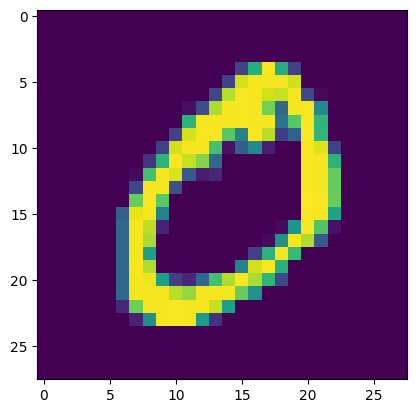

In [95]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0])

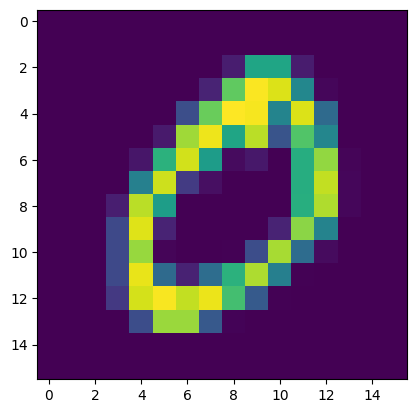

In [96]:
img_test = rescale(train_images[0], 16/28)
plt.imshow(img_test)

In [244]:
#resizing the train and test datasets from (28, 28) to (16, 16)
BAS = []
for img in train_images:
  img = rescale(img, 16/28, anti_aliasing=False)
  img = img.flatten()
  BAS.append(img)

BAS_test = []
for img in test_images:
  img = rescale(img, 16/28, anti_aliasing=False)
  img = img.flatten()
  BAS_test.append(img)

In [98]:
BAS[0].shape

(256,)

In [99]:
16*16

256

In [100]:
2**8 #so 8 qubits circuit needed

256

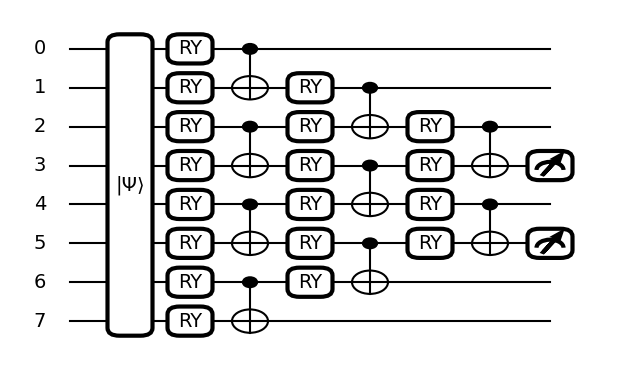

In [51]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev)
def circuit(image, template_weights):
    qml.AmplitudeEmbedding(features=image, wires=range(8), normalize=True)

    i = 0
    while(i < 8):
      qml.RY(template_weights[i], wires=i)
      i = i+1

    for j in range(0, 7, 2):
      qml.CNOT(wires=[j, j+1])

    for j in range(1, 6, 2):
      qml.RY(template_weights[i], wires=j)
      i = i+1
      qml.RY(template_weights[i], wires=j+1)
      i = i+1
      qml.CNOT(wires=[j, j+1])

    for j in range(0, 7, 2):
      qml.RY(template_weights[i], wires=j)
      i = i+1
      qml.RY(template_weights[i], wires=j+1)
      i = i+1
      qml.CNOT(wires=[j, j+1])

    for j in range(1, 6, 2):
      qml.RY(template_weights[i], wires=j)
      i = i+1
      qml.RY(template_weights[i], wires=j+1)
      i = i+1
      qml.CNOT(wires=[j, j+1])

    #qml.CNOT(wires=[3, 5])

    return qml.probs([3, 5])

weights = np.random.random(size=[18, 1])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(BAS[0], weights)
fig.set_size_inches((6, 3.5))

In [23]:
def block(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)

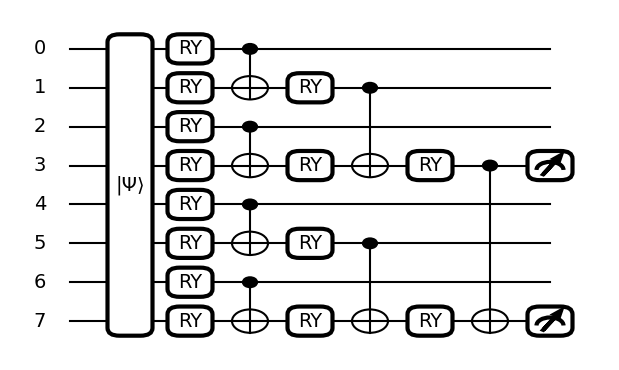

In [24]:
dev = qml.device("default.qubit.autograd", wires=8)


@qml.qnode(dev)
def circuit(image, template_weights):
    qml.AmplitudeEmbedding(features=image, wires=range(8), normalize=True)
    qml.TTN(
        wires=range(8),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    #return qml.density_matrix([3, 7])
    return qml.probs(wires = [3, 7])


weights = np.random.random(size=[7, 2])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(BAS[0], weights)
fig.set_size_inches((6, 3.5))

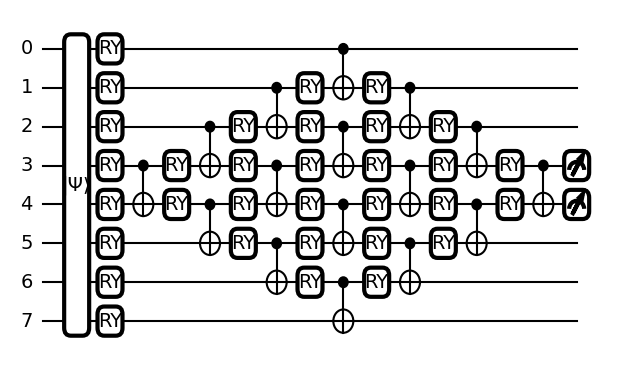

In [233]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev)
def circuit(image, template_weights):
    qml.AmplitudeEmbedding(features=image, wires=range(8), normalize=True)

    i = 0

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    for j in range(1, 6, 2):
      qml.RY(template_weights[i], wires=j)
      i = i+1
      qml.RY(template_weights[i], wires=j+1)
      i = i+1
      qml.CNOT(wires=[j, j+1])

    for j in range(0, 7, 2):
      qml.RY(template_weights[i], wires=j)
      i = i+1
      qml.RY(template_weights[i], wires=j+1)
      i = i+1
      qml.CNOT(wires=[j, j+1])

    for j in range(1, 6, 2):
      qml.RY(template_weights[i], wires=j)
      i = i+1
      qml.RY(template_weights[i], wires=j+1)
      i = i+1
      qml.CNOT(wires=[j, j+1])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])


    return qml.probs([3, 4])

weights = np.random.random(size=[32, 1])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(BAS[0], weights)
fig.set_size_inches((6, 3.5))

In [102]:
def costfunc(params):
    cost = 0
    y_true = [np.array([1, 0, 0, 0]), np.array([0, 1, 0, 0]), np.array([0, 0, 1, 0]), np.array([0, 0, 0, 1])]
    for i in range(len(BAS)):
      prob = circuit(BAS[i], params)
      if train_labels[i] == 0:
        cost -= 1/len(BAS) * np.sum(np.sum(y_true[0].astype(float)*np.log(prob.astype(float))))
      elif train_labels[i] == 1:
        cost -= 1/len(BAS) * np.sum(np.sum(y_true[1].astype(float)*np.log(prob.astype(float))))
      elif train_labels[i] == 2:
        cost -= 1/len(BAS) * np.sum(np.sum(y_true[2].astype(float)*np.log(prob.astype(float))))
      elif train_labels[i] == 3:
        cost -= 1/len(BAS) * np.sum(np.sum(y_true[3].astype(float)*np.log(prob.astype(float))))
    return cost

In [198]:
#import numpy as np
from focal_loss import sparse_categorical_focal_loss
def costfunc(params):
    cost = 0
    y_pred = []
    for i in range(len(BAS)):
        y_pred.append(list(circuit(BAS[i], params)[0]))
    for i in range(len(y_pred)):
        for j in range(4):
            try:  
                y_pred[i][j] = y_pred[i][j].numpy()
            except:
                y_pred[i][j] = float(y_pred[i][j]._value)
    loss = sparse_categorical_focal_loss(train_labels, y_pred, gamma=0.5)
    np.set_printoptions(precision=3)

    cost += np.sum(loss.numpy())
    return cost

In [246]:
def costfunc(params):
    alpha = 1
    gamma = 1.5
    cost = 0
    y_true = [np.array([1, 0, 0, 0]), np.array([0, 1, 0, 0]), np.array([0, 0, 1, 0]), np.array([0, 0, 0, 1])]
    for i in range(len(BAS)):
      prob = circuit(BAS[i], params)
      #print(prob)
      if train_labels[i] == 0:
        x = 1/len(BAS) * np.sum(np.sum(y_true[0].astype(float)*np.log(prob.astype(float))))
        cost -= x * alpha*(1-prob[0][0])**gamma
      elif train_labels[i] == 1:
        x = 1/len(BAS) * np.sum(np.sum(y_true[1].astype(float)*np.log(prob.astype(float))))
        cost -= x * alpha*(1-prob[0][1])**gamma
      elif train_labels[i] == 2:
        x = 1/len(BAS) * np.sum(np.sum(y_true[2].astype(float)*np.log(prob.astype(float))))
        cost -= x * alpha*(1-prob[0][2])**gamma
      elif train_labels[i] == 3:
        x = 1/len(BAS) * np.sum(np.sum(y_true[3].astype(float)*np.log(prob.astype(float))))
        cost -= x * alpha*(1-prob[0][3])**gamma
    return cost

In [247]:
len(BAS)

400

In [248]:
# training the circuit parameters
x2 = np.random.random(size=[32, 1], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.1)

for k in range(91):
    if k % 5 == 0:
      print(f"Step {k}, cost: {costfunc(params)}")
    params = optimizer.step(costfunc, params)
print(params)

Step 0, cost: 0.9070963788358513
Step 5, cost: 0.7054282907118584
Step 10, cost: 0.6475992872510249
Step 15, cost: 0.610418334357068
Step 20, cost: 0.5784649065955477
Step 25, cost: 0.566115402120835
Step 30, cost: 0.5594310738194667
Step 35, cost: 0.550424127999915
Step 40, cost: 0.545981298205799
Step 45, cost: 0.5416842972696985
Step 50, cost: 0.5396607346369341
Step 55, cost: 0.5349550230619103
Step 60, cost: 0.5308204276781952
Step 65, cost: 0.5268790885116867
Step 70, cost: 0.5245834091538054
Step 75, cost: 0.5241694279586433
Step 80, cost: 0.5232626686353418
Step 85, cost: 0.5227272679135133
Step 90, cost: 0.5225117134113217
[[-0.579]
 [ 1.245]
 [-0.623]
 [ 1.708]
 [ 1.545]
 [-1.666]
 [ 0.552]
 [-0.693]
 [ 1.192]
 [ 1.44 ]
 [-0.003]
 [ 1.34 ]
 [ 0.682]
 [ 0.846]
 [-0.275]
 [ 1.125]
 [ 1.764]
 [ 1.506]
 [ 0.85 ]
 [ 0.599]
 [-0.569]
 [ 1.715]
 [ 0.227]
 [ 0.93 ]
 [ 0.014]
 [ 0.184]
 [ 0.113]
 [ 2.001]
 [ 0.242]
 [ 1.227]
 [-0.831]
 [ 0.71 ]]


In [249]:
i = -1
train_correct = 0
labels = [np.array([1, 0, 0, 0]).reshape(1, 4), np.array([0, 1, 0, 0]).reshape(1, 4), np.array([0, 0, 1, 0]).reshape(1, 4), np.array([0, 0, 0, 1]).reshape(1, 4)]
for img in BAS:
      i = i + 1
      x = circuit(img, params)
      #print(x)
      x2 = []
      x2.append(float(x[0][0]))
      x2.append(float(x[0][1]))
      x2.append(float(x[0][2]))
      x2.append(float(x[0][3]))
      #print(x2)
      x3 = max(x2)
      key=x2.index(x3)
      x = key
      #print(x)
      if x == 0 and train_labels[i] == 0:
        train_correct += 1
      elif x == 1 and train_labels[i] == 1:
        train_correct += 1
      elif x == 2 and train_labels[i] == 2:
        train_correct += 1
      elif x == 3 and train_labels[i] == 3:
        train_correct += 1
print("training accuracy:")
print(100*train_correct/len(BAS),"%")

training accuracy:
81.5 %


In [252]:
i = -1
test_correct = 0
labels = [np.array([1, 0, 0, 0]).reshape(1, 4), np.array([0, 1, 0, 0]).reshape(1, 4), np.array([0, 0, 1, 0]).reshape(1, 4), np.array([0, 0, 0, 1]).reshape(1, 4)]
for img in BAS_test:
      i = i + 1
      x = circuit(img, params)
      #print(x)
      x2 = []
      x2.append(float(x[0][0]))
      x2.append(float(x[0][1]))
      x2.append(float(x[0][2]))
      x2.append(float(x[0][3]))
      #print(x2)
      x3 = max(x2)
      key=x2.index(x3)
      x = key
      print(x)
      if x == 0 and test_labels[i] == 0:
        test_correct += 1
      elif x == 1 and test_labels[i] == 1:
        test_correct += 1
      elif x == 2 and test_labels[i] == 2:
        test_correct += 1
      elif x == 3 and test_labels[i] == 3:
        test_correct += 1
print("testing accuracy:")
print(100*test_correct/len(BAS_test),"%")

1
2
1
0
0
1
0
0
1
1
1
1
1
1
0
1
2
0
1
1
2
0
3
1
2
2
2
1
2
0
2
1
2
1
2
2
3
3
1
2
testing accuracy:
75.0 %


In [253]:
len(BAS_test)

40

In [256]:
train_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
